# Importing Libraries and Loading data .

In [1]:
import janestreet 
from tqdm.notebook import tqdm 
import time
import numpy as np
import os ,gc
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datatable as dt 

import tensorflow as tf 
from tensorflow import keras 
import tensorflow_addons as tfa

In [2]:
#setting random seed for reproducibility: 
def set_seed(seed=7):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed=7)

#setting plt.style

plt.style.use('seaborn')

In [3]:
#loading the files 
%time
train_df=dt.fread('../input/jane-street-market-prediction/train.csv').to_pandas().query('weight > 0 and date >85').reset_index(drop=True)
test_df=dt.fread('../input/jane-street-market-prediction/example_test.csv').to_pandas().reset_index(drop=True)
sample_submission=pd.read_csv('../input/jane-street-market-prediction/example_sample_submission.csv')
# features=pd.read_csv('../input/jane-street-market-prediction/features.csv')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [4]:
print('Training set shape {} \n Test set  shape {} '.format(train_df.shape,test_df.shape))

Training set shape (1571415, 138) 
 Test set  shape (15219, 133) 


**Lets visualize the returns columns **

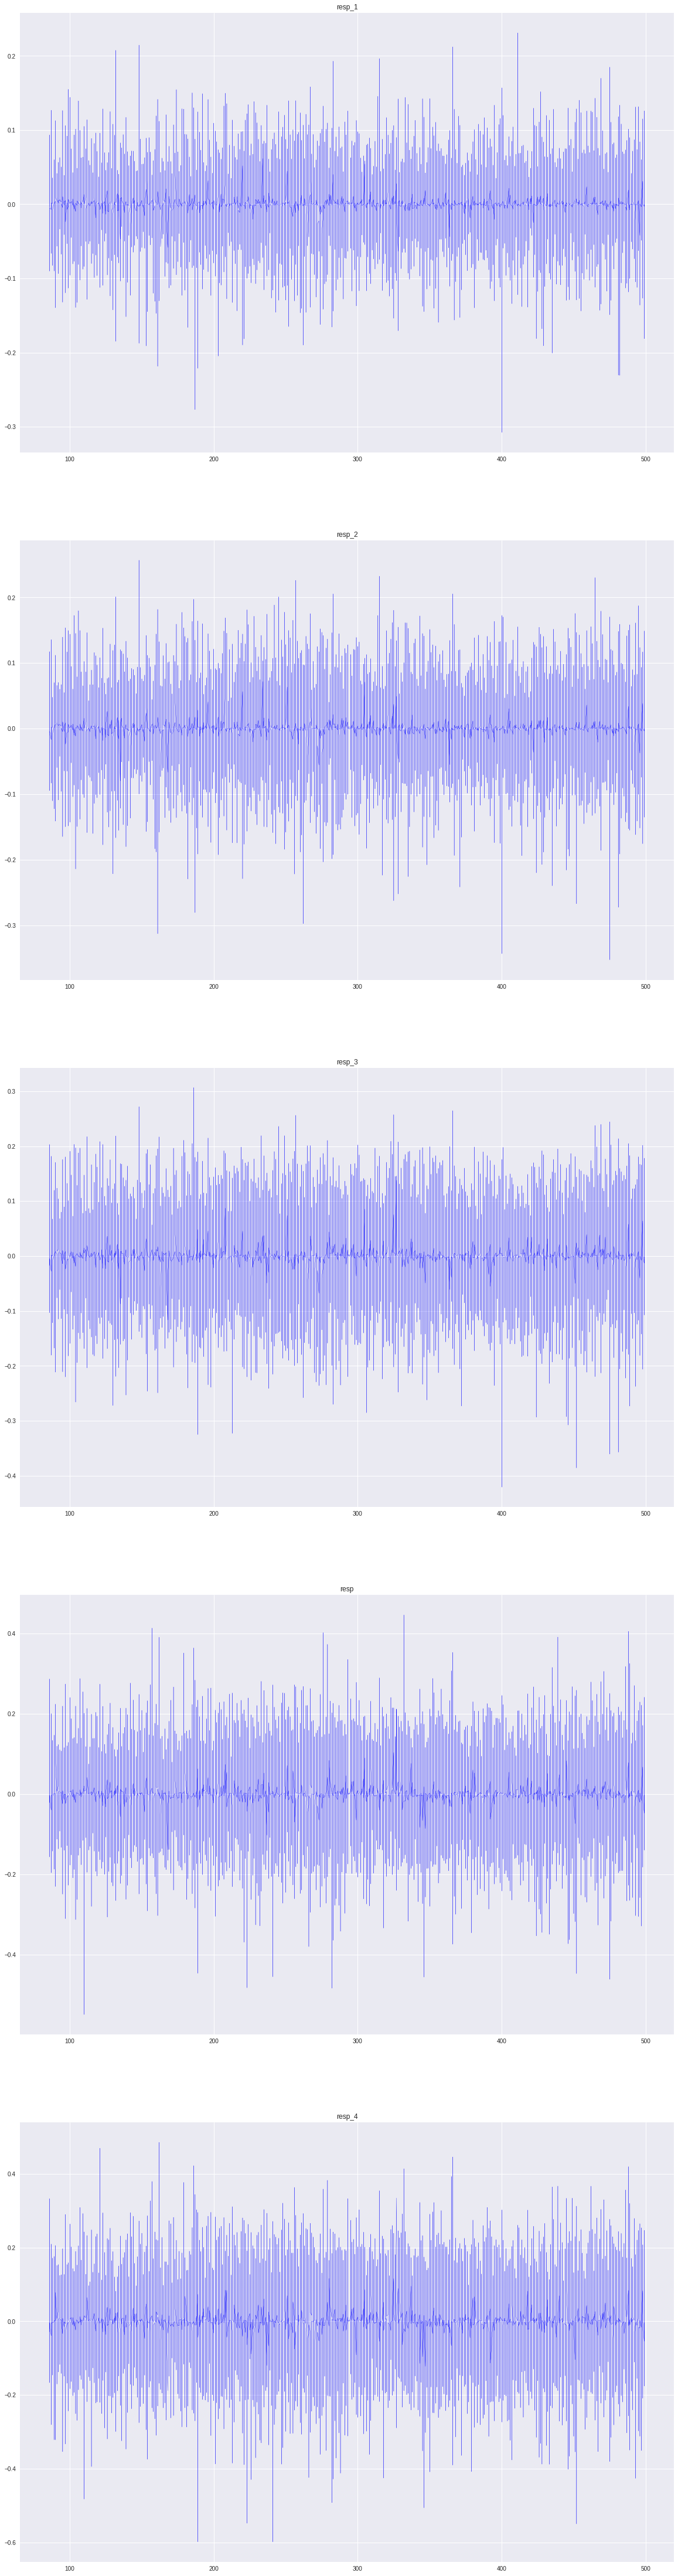

In [5]:
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']


def plot_returns(df,cols):
    plt.figure(figsize=(20,80))
    for i,col in enumerate(cols):
        plt.subplot(5,1,i+1)
        plt.plot(df['date'],df[col],linewidth=.3,color='b')
        plt.title(col)
        plt.legend()
    plt.show()

plot_returns(train_df,resp_cols)

# Preprocessing the data .

**Imputing the data with interpolation and bfill**

In [6]:
#finding % of data that is null and imputing it :

null_val_ratio= train_df.isnull().sum().sum()/np.product(train_df.shape)
print(f'% of null values in train set is {null_val_ratio *100} ')


#imputing data using ffill() ( i.e forward fill) and bfill() (i.e backward fill)
# train_df=train_df.ffill().bfill()

#trying interpolate to fill null values:
train_df=train_df.interpolate(limit_direction='forward',axis=0)
train_df=train_df.bfill()

gc.collect()

% of null values in train set is 2.0016220956954376 


11311

# Building and Training the model: no CrossValidation.

I've tried three models with a little changes in thier architecture,with diffrent Learning rates and diffrent batch sizes.  

Mainly used this notebook for this approach . Credits to the author.[https://www.kaggle.com/code1110/jane-street-with-keras-nn-overfit]

In [7]:
#features to use in training model :
features = train_df.columns[train_df.columns.str.contains('feature')]

#converting the 'resp' values into binary, i.e 1 if >0 else 0 if 0>resp value.
#resp refers to return values, so action = buy if return is +ve else no action if return is -ve.
train_df['action']=(train_df['resp']>0).astype('int')

#target variable and training set :
X_train=train_df[features]
y_train=np.stack([(train_df[c] > 0).astype('int') for c in resp_cols]).T

gc.collect()

47

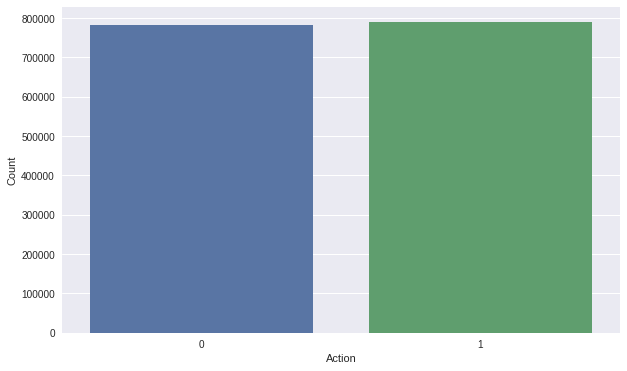

In [8]:
#lets see the class balance :
def plot_countplot(df,col):
    plt.figure(figsize=(10,6))
    sns.countplot(df[col])
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.show()
plot_countplot(train_df,'action')

In [9]:
#build model:
def Build_model( num_columns, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate
):

    inp = tf.keras.layers.Input(shape=(num_columns,))
        
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 1])(x)
    
    x = tf.keras.layers.Dense(num_labels)(x)
    out = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tfa.optimizers.RectifiedAdam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
        metrics=tf.keras.metrics.AUC(name="AUC"),
    )

    return model

In [10]:
#Parameters for model1 
# epochs = 200
# batch_size = 8192
# hidden_units = [256,256,256,128]
# dropout_rates = [0.1,0.15, 0.15, 0.2, 0.15]
# label_smoothing = 1e-2
# learning_rate = 1e-3

# tf.keras.backend.clear_session()


# #model1:
# model1 = Build_model(len(features), 5, hidden_units, dropout_rates, label_smoothing, learning_rate)

# #callbacks:
# #reduce lr
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor = 'AUC', factor = 0.75, patience = 3, verbose = 0, min_delta = 1e-3, mode = 'max')

# model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,callbacks=[reduce_lr])

# gc.collect()

In [11]:
#2nd model
epochs = 200
batch_size = 8192
hidden_units = [256,128,128,64]
dropout_rates = [0.2,0.25, 0.25, 0.2, 0.15]
label_smoothing = 1e-2
learning_rate = 1e-2

tf.keras.backend.clear_session()

model2 = Build_model(len(features), 5, hidden_units, dropout_rates, label_smoothing, learning_rate)

#callbacks:


#reduce learning rate 
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'AUC', factor = 0.75, patience = 3, verbose = 0, min_delta = 1e-3, mode = 'max',min_lr=1e-8)


#early stopping
early_stopping=keras.callbacks.EarlyStopping(patience=15,min_delta=1e-2,monitor='loss',restore_best_weights=True)

#training
model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,callbacks=[reduce_lr,early_stopping])

gc.collect()

Epoch 1/200
192/192 [==============================] - 39s 205ms/step - loss: 0.7026 - AUC: 0.5213
Epoch 2/200
192/192 [==============================] - 39s 204ms/step - loss: 0.6907 - AUC: 0.5382
Epoch 3/200
192/192 [==============================] - 38s 198ms/step - loss: 0.6898 - AUC: 0.5424
Epoch 4/200
192/192 [==============================] - 39s 204ms/step - loss: 0.6894 - AUC: 0.5447
Epoch 5/200
192/192 [==============================] - 38s 199ms/step - loss: 0.6891 - AUC: 0.5466
Epoch 6/200
192/192 [==============================] - 38s 196ms/step - loss: 0.6888 - AUC: 0.5479
Epoch 7/200
192/192 [==============================] - 37s 192ms/step - loss: 0.6886 - AUC: 0.5491
Epoch 8/200
192/192 [==============================] - 37s 190ms/step - loss: 0.6884 - AUC: 0.5502
Epoch 9/200
192/192 [==============================] - 46s 238ms/step - loss: 0.6881 - AUC: 0.5511
Epoch 10/200
192/192 [==============================] - 40s 209ms/step - loss: 0.6880 - AUC: 0.5515
Epoch 11/

3006

In [12]:
#3rd model:
epochs = 200
batch_size = 8192
hidden_units = [256,128,64]
dropout_rates = [0.2,0.25, 0.20, 0.2]
label_smoothing = 1e-2
learning_rate = 1e-1

tf.keras.backend.clear_session()

model3= Build_model(len(features), 5, hidden_units, dropout_rates, label_smoothing, learning_rate)

#callbacks:
#reduce lr
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'AUC', factor = 0.50, patience = 3, verbose = 0, min_delta = 1e-3, mode = 'max',min_lr=1e-8)

#early stopping
early_stopping=keras.callbacks.EarlyStopping(patience=15,min_delta=1e-3,monitor='loss',restore_best_weights=True)

#training
model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,callbacks=[reduce_lr,early_stopping])

gc.collect()

Epoch 1/200
192/192 [==============================] - 34s 177ms/step - loss: 0.6959 - AUC: 0.5292
Epoch 2/200
192/192 [==============================] - 35s 183ms/step - loss: 0.6898 - AUC: 0.5423
Epoch 3/200
192/192 [==============================] - 35s 182ms/step - loss: 0.6893 - AUC: 0.5450
Epoch 4/200
192/192 [==============================] - 35s 183ms/step - loss: 0.6891 - AUC: 0.5458
Epoch 5/200
192/192 [==============================] - 35s 182ms/step - loss: 0.6888 - AUC: 0.5478
Epoch 6/200
192/192 [==============================] - 34s 178ms/step - loss: 0.6887 - AUC: 0.5479
Epoch 7/200
192/192 [==============================] - 35s 181ms/step - loss: 0.6885 - AUC: 0.5490
Epoch 8/200
192/192 [==============================] - 47s 242ms/step - loss: 0.6883 - AUC: 0.5498
Epoch 9/200
192/192 [==============================] - 33s 172ms/step - loss: 0.6881 - AUC: 0.5511
Epoch 10/200
192/192 [==============================] - 35s 180ms/step - loss: 0.6880 - AUC: 0.5512
Epoch 11/

820

# Inference:


In [13]:
models=[model2,model3]
#inference:
th = 0.491
f = np.median
env = janestreet.make_env()
for (test_df, pred_df) in tqdm(env.iter_test()):
    test_df=test_df.interpolate(limit_direction='forward',axis=0)
    test_df=test_df.bfill()
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, features].values
        pred = np.mean([model(x_tt, training = False).numpy() for model in models],axis=0)
        pred=f(pred)
        pred_df.action = np.where(pred >= th, 1, 0).astype(int)
    else:
        pred_df.action = 0
    env.predict(pred_df)